## Importing libraries

In [1]:
install.packages("lme4")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Rdpack’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’




In [2]:
library(tidyverse)
library(MASS)
library(lme4)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [3]:
# To make plots
theme <- theme(
            plot.title = element_text(size=20,face="bold"),
            legend.position = "top",
            legend.title = element_blank(),
            axis.text = element_text(size=15),
            axis.title = element_text(size=18,face="bold"),
            axis.line = element_line(colour = "black"),
            plot.margin = unit(c(1, 2, 1, 1), "lines"),
            panel.background = element_blank())

## Participant list


First, you got a cohort participant list from local staff.


*   Cohort children are supposed to be aged 6 month to 14 years old.

*   Variables are the following:

    1.   **cluster_id**: ID for each cluster
    2.   **cohort_id**: Unique identifier for each participant
    3. **name_f**: First name of the participant
    4. **name_l**: Last name of the participant
    5. **birth**: Birthday of the participant
    6. **name_labtec**: Name of lab tech respondible for the cluster



In [5]:
df_cohort <- read.csv("./list_cohort.csv")

In [7]:
head(df_cohort,10)

,cluster_id,cohort_id,name_f,name_l,birth,name_labtec
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cl01,cl01_01,Sakeena,al-Hoque,2012-03-26,Nicole
2,cl01,cl01_02,Mitchell,Gonzales,2017-01-02,Nicole
3,cl01,cl01_03,Anthony,Simmons,2024-08-15,Nicole
4,cl01,cl01_04,Alyssa,Rivera,2016-10-03,Nicole
5,cl01,cl01_05,Timothy,Vlajic,2015-09-10,Nicole
6,cl01,cl01_06,Mana,White,2018-08-09,Nicole
7,cl01,cl01_07,Chykeiljah,Rea,2022-05-22,Nicole
8,cl01,cl01_08,Laneesha,Rusk,2011-07-23,Nicole
9,cl01,cl01_09,Mujaahida,el-Malak,2021-01-02,Nicole


In [8]:
# How many cluster IDs?
unique(df_cohort$cluster_id)

[1] "cl01" "cl02" "cl03" "cl04" "cl05" "cl06" "cl07" "cl08" "cl09" "cl10"
[11] "cl11" "cl12" "cl13" "cl14" "cl15" "cl16" "cl17" "cl18" "cl19" "cl20"

In [9]:
# Number of participants per cluster
df_cohort %>% count(cluster_id)

cluster_id,n
<chr>,<int>
cl01,38
cl02,38
cl03,38
cl04,38
cl05,38
cl06,38
cl07,38
cl08,38
cl09,38


In [10]:
# Lab tech name?
print(unique(df_cohort$name_labtec))

 [1] " Nicole"     " Luis"       " Rustin"     " Phuc Danny" " Kimberly"  
 [6] " Ghaaziya"   " Clifford"   " Antonia"    " Felonice"   " Jordan"    
[11] " Hysoonie"   " Saleet"     " Michael"    " Patrick"    " Darian"    
[16] " Sean"       " Megan"      " Sharaf"     " Rashiah"    " Aaron"     


In [11]:
# Age of participants?
date_survey <- as.Date("2025/04/01")
df_cohort$age <- floor(interval(df_cohort$birth, date_survey) / years(1))

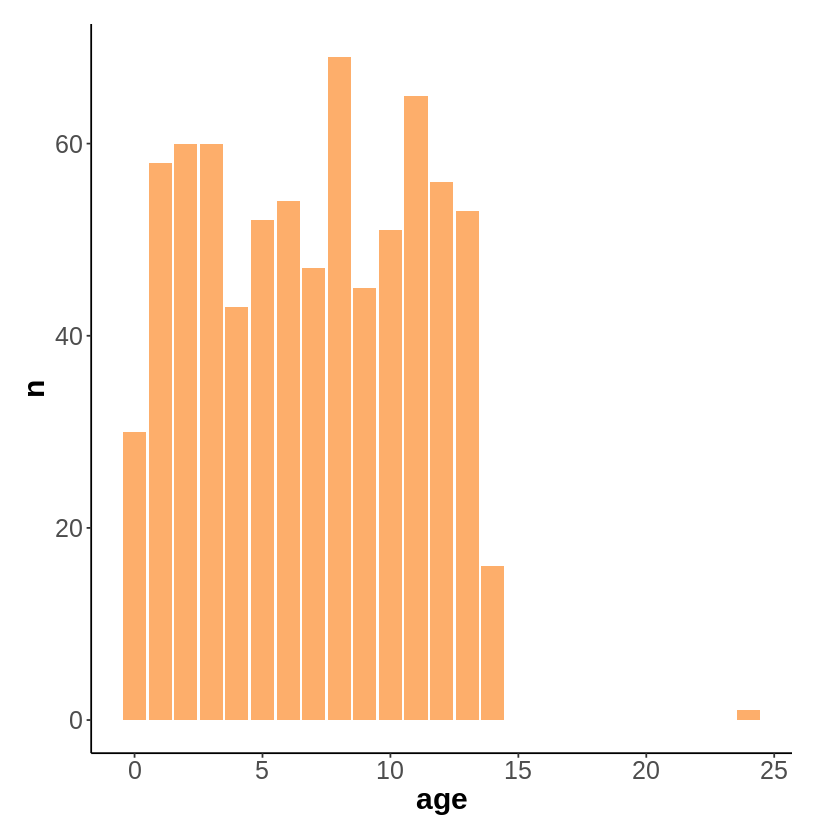

In [12]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
  geom_bar(stat = "identity", fill = "#fdae6b")+
  theme

In [13]:
df_cohort %>% filter(age > 14)

cluster_id,cohort_id,name_f,name_l,birth,name_labtec,age
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
cl01,cl01_11,Austin,Smith,2000/11/30,Nicole,24


Oh, why was the 24 y.o adult, Austin, included in the cohort list?

Let's ask Nicole, the lab tech for cluster 'cl01'. Then, you may find that the incorrect birthday was recorded.

Her true birthday is November 30, 2020!

We need to fix the data set.

In [14]:
df_cohort <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = ifelse(cohort_id == "cl01_11", 3, age))

In [15]:
df_cohort %>% filter(cohort_id == "cl01_11")

cluster_id,cohort_id,name_f,name_l,birth,name_labtec,age
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
cl01,cl01_11,Austin,Smith,2020/11/30,Nicole,3


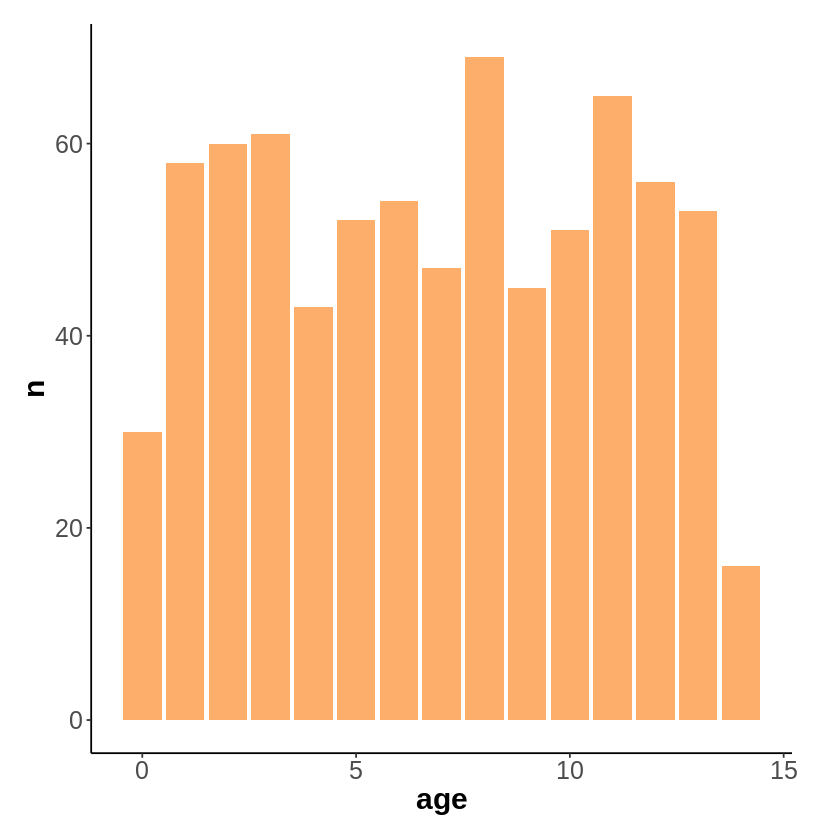

In [16]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
   geom_bar(stat = "identity", fill = "#fdae6b")+
   theme

## Baseline data

We have the following information associated with malaria outcomes.



1.   **intervention**: Intervention or Control assignment (1: intervention, 0: control)
2.   **cn**: Living in the household with ceiling net or not (1: with cn, 0: without cn)
3. **non_bn**: Not using bed net (1: non-user, 0: user)
4. **vac**: With malaria vaccination for those aged 2–6 years old (1: vaccinated)
5. **age_c**: age category (1: age <= 2 yo, 0: age > 2 yo)
6. **rdt**: RDT results


In [19]:
df_baseline <- read.csv("./data_baseline.csv")
head(df_baseline)

,cluster_id,cohort_id,birth,age,intervention,cn,non_bn,vac,age_c,rdt
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,cl01,cl01_01,2012-03-26,13,1,1,0,0,0,0
2,cl01,cl01_02,2017-01-02,8,1,1,0,0,0,1
3,cl01,cl01_03,2024-08-15,0,1,1,0,0,1,0
4,cl01,cl01_04,2016-10-03,8,1,1,0,0,0,0
5,cl01,cl01_05,2015-09-10,9,1,1,0,0,0,0
6,cl01,cl01_06,2018-08-09,6,1,1,0,1,0,0


Transmission heterogeneity

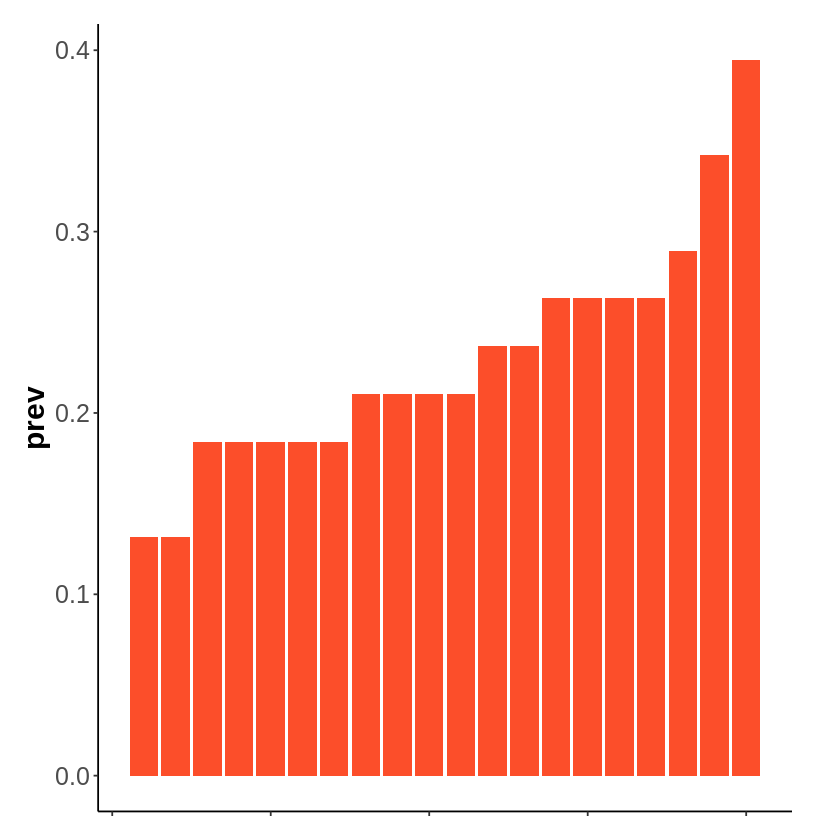

In [26]:
df_prev <- df_baseline %>%
  group_by(cluster_id) %>%
  count(rdt) %>%
  mutate(prev = n/sum(n)) %>%
  filter(rdt == 1) %>%
  arrange(prev) %>%
  ungroup() %>%
  mutate(order = row_number())

ggplot(data = df_prev, aes(x = order, y = prev))+
   geom_bar(stat = "identity", fill = "#fc4e2a")+
   theme+
   theme(
          axis.title.x = element_blank(),
          axis.text.x = element_blank()
   )

# Analysis of perfect data

### Data generation process

1.   **Cluster-level random effect**: mean = 0, sd = 0.5
2.   **Intervention**: Randomly assign 50% of participants to receive the intervention, which reduces the risk of clinical malaria by 50%.
3.   **Compliance**: 10% of participants do not receive the intervention when allocated to the intervention arm due to a lack of health awareness; these individuals have a 20% higher risk of clinical malaria.
4.   **Bed net use**: 20% of participants do not use bed nets regularly and have a 40% higher risk of clinical malaria.
5.   **Malaria vaccine**: 70% of children aged 2–6 years receive a malaria vaccine, which reduces the risk of clinical malaria by 30%.
6. **Age**: Children aged 0–2 years have a 50% higher risk of clinical malaria compared to older children.

Without any of the above risk factors, the incidence rate is 1.5 per person-year, following a negative binomial distribution with a dispersion parameter of 1.2


\begin{align*}
y_{ij} &\sim NegBin(\lambda_{ij}, \theta) \\
\log{\lambda_{ij}} &= \alpha + x_{ij}^T\beta + u_j \\
\ u_j &\sim N(0, \sigma_{u}^2) \\
\end{align*}

In [32]:
df_full <- read.csv("./data_cohort_full.csv")
head(df_full)

,cohort_id,visit,outcome,cluster_id,name_f,name_l,birth,name_labtec,age,re,intervention,cn,non_comp,non_bn,vac,age_c
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,cl01_01,1,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0
2,cl01_01,2,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0
3,cl01_01,3,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0
4,cl01_01,4,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0
5,cl01_01,5,0,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0
6,cl01_01,6,1,cl01,Sakeena,al-Hoque,2012/03/26,Nicole,13,-0.2503978,1,1,0,0,0,0


In [28]:
df_full_count <- df_full %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome),
    total_visit = n()
  )

In [29]:
df_full <- df_full %>%
    dplyr::select(cluster_id, cohort_id, intervention, cn, non_comp, non_bn, vac, age_c) %>%
    left_join(df_full_count, by = "cohort_id") %>%
    distinct(cohort_id, .keep_all = T)

In [30]:
model <- glmer.nb(num_pos ~
                       cn +
                       non_comp +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_full)

In [31]:
print(exp(fixef(model)))
exp(confint(model, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model))[[2]],2)))

(Intercept)          cn    non_comp      non_bn         vac       age_c 
  0.1228262   0.5104337   1.4220579   1.2569324   0.7169945   1.3920507 


,2.5 %,97.5 %
(Intercept),0.09708239,0.1553966
cn,0.37308121,0.6983535
non_comp,1.05054529,1.9249513
non_bn,1.00850783,1.5665512
vac,0.57512895,0.8938537
age_c,1.10753742,1.7496521


[1] "Estimated efficacy of the ceiling net: 0.49"


# Analysis of raw data

In [34]:
df_raw <- read.csv("./data_cohort_raw.csv")
df_raw

cluster_id,cohort_id,visit,avail,name_f,name_l,symp,rdt
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>
cl01,cl01_01,1,1,Sakeena,al-Hoque,0,0
cl01,cl01_01,2,1,Sakeena,al-Hoque,0,0
cl01,cl01_01,3,0,Sakeena,al-Hoque,0,0
cl01,cl01_01,4,0,Sakeena,al-Hoque,0,1
cl01,cl01_01,5,1,Sakeena,al-Hoque,0,0
cl01,cl01_01,6,1,Sakeena,al-Hoque,1,1
cl01,cl01_01,7,1,Sakeena,al-Hoque,0,0
cl01,cl01_01,8,1,Sakeena,al-Hoque,0,0
cl01,cl01_01,9,1,Sakeena,al-Hoque,0,0


We need the results regarding clinical malaria

= symptoms + RDT positive


In [36]:
df_raw2 <- df_raw %>%
    mutate(outcome = ifelse(rdt == 1 & symp == 1, 1, 0))

In [37]:
df_raw2

cluster_id,cohort_id,visit,avail,name_f,name_l,symp,rdt,outcome
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>
cl01,cl01_01,1,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,2,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,3,0,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,4,0,Sakeena,al-Hoque,0,1,0
cl01,cl01_01,5,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,6,1,Sakeena,al-Hoque,1,1,1
cl01,cl01_01,7,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,8,1,Sakeena,al-Hoque,0,0,0
cl01,cl01_01,9,1,Sakeena,al-Hoque,0,0,0


In [38]:
df_raw_count <- df_raw2 %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome,na.rm=T),
    total_visit = sum(avail)
  )




*   Combine with the baseline covariates
*   Calcluate incidence rate per person-year



In [39]:
df_raw3 <- left_join(df_raw_count, df_baseline) %>%
    distinct(cohort_id, .keep_all = T) %>%
    mutate(incidence_rate = 12*num_pos/total_visit)

Joining with `by = join_by(cohort_id)`


In [40]:
df_raw3

cohort_id,num_pos,total_visit,cluster_id,birth,age,intervention,cn,non_bn,vac,age_c,rdt,incidence_rate
<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
cl01_01,1,9,cl01,2012-03-26,13,1,1,0,0,0,0,1.333333
cl01_02,0,12,cl01,2017-01-02,8,1,1,0,0,0,1,0.000000
cl01_03,1,11,cl01,2024-08-15,0,1,1,0,0,1,0,1.090909
cl01_04,0,12,cl01,2016-10-03,8,1,1,0,0,0,0,0.000000
cl01_05,1,11,cl01,2015-09-10,9,1,1,0,0,0,0,1.090909
cl01_06,2,11,cl01,2018-08-09,6,1,1,0,1,0,0,2.181818
cl01_07,1,12,cl01,2022-05-22,2,1,1,0,1,1,0,1.000000
cl01_08,0,11,cl01,2011-07-23,13,1,1,0,0,0,0,0.000000
cl01_09,0,12,cl01,2021-01-02,4,1,1,0,1,0,0,0.000000


Get estimates

  - Intention to treeat vs Per protocol

In [41]:
# Intention to Treat
model_raw_itt <- glmer.nb(num_pos ~ intervention +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [42]:
# Per protocol
model_raw_pp <- glmer.nb(num_pos ~ cn +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [43]:
# Intention to Treat
print(exp(fixef(model_raw_itt)))
exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_itt))[[2]],2)))

 (Intercept) intervention       non_bn          vac        age_c 
   0.1365816    0.5732188    1.2852269    0.7065125    1.3550817 


,2.5 %,97.5 %
(Intercept),0.1078924,0.1728993
intervention,0.4159276,0.7899927
non_bn,1.0262208,1.6096031
vac,0.5647866,0.8838026
age_c,1.0735961,1.7103697


[1] "Estimated efficacy of the ceiling net: 0.43"


In [44]:
# Per protocol
print(exp(fixef(model_raw_pp)))
exp(confint(model_raw_pp, parm = "beta_", method = "Wald"))


print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_pp))[[2]],2)))

(Intercept)          cn      non_bn         vac       age_c 
  0.1452063   0.4364840   1.2706074   0.7071418   1.4044077 


,2.5 %,97.5 %
(Intercept),0.1166879,0.1806945
cn,0.3260382,0.5843436
non_bn,1.0179101,1.5860371
vac,0.5664871,0.8827200
age_c,1.1156512,1.7679011


[1] "Estimated efficacy of the ceiling net: 0.56"


## Data simulation


### Data generation process

1.   **Cluster-level random effect**: mean = 0, sd = 0.3
2.   **Intervention**: Randomly assing 50% to receive the intervention with 50% risk reduction in clinical malaria
3.   **Compliance**: 10% of participants do not accept the intervention due to the lack of health awareneses and they have 20% higher risk of clinical malaria
4.   **Bed net use**: 20% of participants do not use bed nets regularly and they have 40% higher risk of clinical malaria
5.   **Malaria vaccine**: 70% of children aged 2–6 years with malaria vaccines which reduces 30% of clinical malaria risk
6. **Age**: Children aged 0–2 years have 50% higher clinical malaria risk compared to older children

Without the above-mentioned any risk factor, incidence rate is 1.5 per person-year following a negative binomial distribution with dispersion parameter 1.2


\begin{align*}
y_{ij} &\sim NegBin(\lambda_{ij}, \theta) \\
\log{\lambda_{ij}} &= \alpha + x_{ij}^T\beta + u_j \\
\ u_j &\sim N(0, \sigma_{u}^2) \\
\end{align*}







In [ ]:
df_cohort <- read.csv("./data/list_cohort.csv")
date_survey <- as.Date("2025/04/01")
df_cohort_2 <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = floor(interval(birth, date_survey) / years(1))) %>%
  group_by(cluster_id) %>%
  mutate(re = rnorm(1, mean = 0, sd = 0.3)) %>%
  mutate(intervention = ifelse(as.numeric(str_extract(cluster_id, "\\d+")) %% 2 == 1,1,0)) %>%
  ungroup() %>%
  mutate(non_comp = rbinom(nrow(df_cohort), 1, 0.10),
         non_bn = rbinom(nrow(df_cohort), 1, 0.2),
         vac = case_when(age >= 2 & age <= 6 ~ rbinom(nrow(df_cohort), 1, 0.70),
                         TRUE ~ 0),
         age_c = ifelse(age <= 2, 1, 0)) %>% # 1: young, 0: old
  mutate(cn = ifelse(intervention == 1 & non_comp == 0, 1, 0))

In [ ]:
lambda <- exp(log(1.5)+df_cohort_2$re+
            log(0.5)*df_cohort_2$cn+
            log(1.2)*df_cohort_2$non_comp+
            log(1.4)*df_cohort_2$non_bn+
            log(0.7)*df_cohort_2$vac+
            log(1.5)*df_cohort_2$age_c
            )
theta <- 1.2
num_pos <- rnegbin(nrow(df_cohort_2), mu = lambda, theta = theta)
df_cohort_2$num_pos <- num_pos

In [ ]:
print(df_cohort_2$num_pos)

  [1]  1  0  1  0  1  2  1  0  0  0  0  0  0  2  0  2  0  0  0  0  1  0  2  0  0
 [26]  0  3  0  1  0  3  0  4  1  0  0  0  1  1  1  1  1  0  0  3  1  1  1  2  0
 [51]  4  1  0  0  0  0  1  0  1  0  0  3  0  0  1  6  0  0  2  4  2  0  0  5  0
 [76]  2  0  0  1  0  1  2  0  6  0  2  1  0  6  0  0  1  1  0  0  3  3  4  2  4
[101]  0  1  0  1  1  1  3  0  1  0  1  0  1  0  4  7  1  3  1  2  1  2  0  2  2
[126]  1  2  3  1  5  2  5  1  1  4  3  8  3  1  2  1  3  2  0  0  0  5  2  0  0
[151] 10  0  2  2  6  2  0  2  2  0  0  0  0  0  0  3  4  0  1  0  0  2  1  0  0
[176]  3  1  1  0  3  1  0  1  0  0  0  2  0  0  4  5  0  1  0  1  4  0  3  3  0
[201]  5  2  0  3  0  2  1  6  2  2  1  0  2  3  1  9  4  0  1  4  6  1  5  0  0
[226]  0  0  7  5  0  4  2  1  0  9  0  0  1  1  2  0  0  1  2  0  1  1  0  0  1
[251]  0  4  1  0  2  2  0  0  1  1  0  1  2  0  3  0  4  0  0  3  0  1  1  1  1
[276]  0  3  1  1  0  0  3  8  0  0  0  1  0  3  4  0  2  0  3  0  0  1  0  0  1
[301]  4  2  1  3  1  1  0  

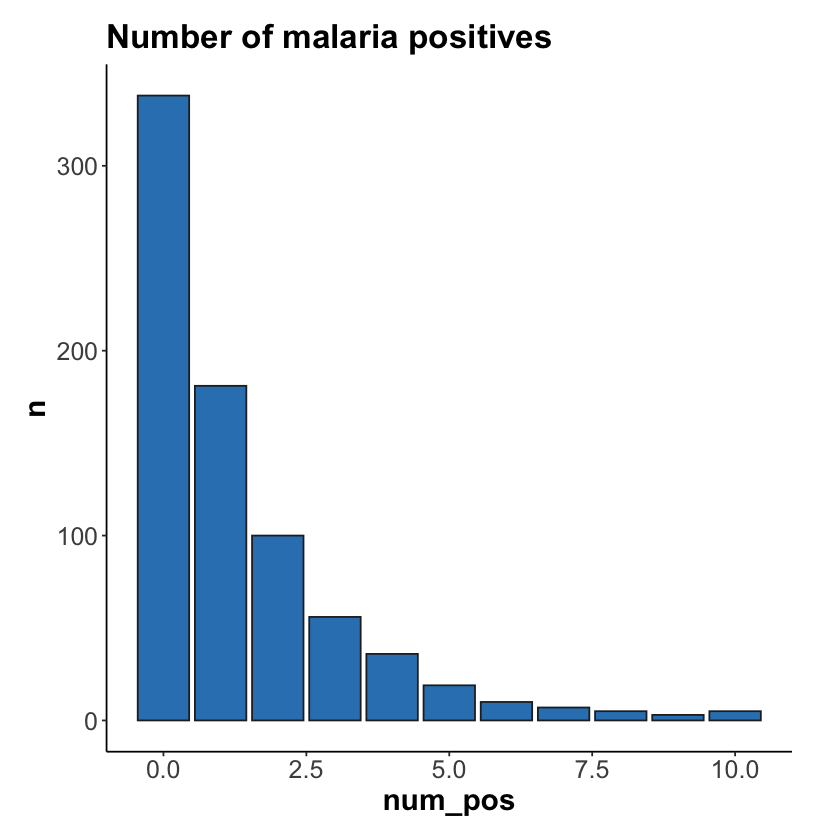

In [ ]:
df_num_pos <- df_cohort_2 %>% count(num_pos)

ggplot(data = df_num_pos, aes(x = num_pos, y = n))+
   geom_bar(stat = "identity", fill = "#3182bd", color = "#252525")+
   ggtitle("Number of malaria positives")+
   theme

### Estimates

In [ ]:
model_true <- glmer.nb(num_pos ~
                       cn +
                       non_comp +
                       non_bn +
                       vac +
                       age_c +
                       (1 | cluster_id), data = df_cohort_2)

In [ ]:
model_pp <- glmer.nb(num_pos ~
                       cn +
                       non_bn +
                       vac +
                       age_c +
                       (1 | cluster_id), data = df_cohort_2)

In [ ]:
model_itt <- glmer.nb(num_pos ~
                       intervention +
                       non_bn +
                       vac +
                       age_c +
                       (1 | cluster_id), data = df_cohort_2)

In [ ]:
print(exp(fixef(model_true)))

(Intercept)          cn    non_comp      non_bn         vac       age_c 
  1.4739221   0.5104331   1.4220520   1.2569294   0.7169912   1.3920480 


In [ ]:
print(exp(fixef(model_pp)))

(Intercept)          cn      non_bn         vac       age_c 
  1.6580925   0.4291437   1.2670424   0.7067779   1.4062556 


In [ ]:
print(exp(fixef(model_itt)))

 (Intercept) intervention       non_bn          vac        age_c 
   1.5442046    0.5776051    1.2834086    0.7067913    1.3569822 


In [ ]:
exp(confint(model_true, parm = "beta_", method = "Wald"))

,2.5 %,97.5 %
(Intercept),1.1649945,1.8647695
cn,0.3730803,0.6983535
non_comp,1.0505415,1.9249424
non_bn,1.0085038,1.5665498
vac,0.5751258,0.8938502
age_c,1.1075344,1.7496502


In [ ]:
df_res <- tibble(
  cohort_id = rep(df_cohort_2$cohort_id, each = 12),
  visit = rep(1:12, times = nrow(df_cohort_2)),
  total_pos = rep(df_cohort_2$num_pos, each = 12)) %>%
  group_by(cohort_id) %>%
  mutate(
    outcome = {
      n_visits <- n()
      n_ones <- first(total_pos)
      assigned <- rep(0, n_visits)
      assigned[sample(n_visits, n_ones)] <- 1
      assigned
    }
  ) %>%
  ungroup() %>%
  left_join(df_cohort_2)

Joining with `by = join_by(cohort_id)`


In [ ]:
head(df_res)

cohort_id,visit,total_pos,outcome,cluster_id,name_f,name_l,birth,name_labtec,age,re,intervention,non_comp,non_bn,vac,age_c,cn,num_pos
<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
cl01_01,1,1,0,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1
cl01_01,2,1,0,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1
cl01_01,3,1,0,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1
cl01_01,4,1,0,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1
cl01_01,5,1,0,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1
cl01_01,6,1,1,cl01,Sakeena,al-Hoque,2012-03-26,Nicole,13,-0.2503978,1,0,0,0,0,1,1


In [ ]:
library(writexl)
write_xlsx(df_res,"df_res.xlsx")

In [ ]:
df_var <- df_res %>%
    dplyr::select(cluster_id, cohort_id, birth, age, intervention, cn, non_comp, non_bn, vac, age_c)
write_csv(df_var,"data_var.csv")
